# Task 1. HMM Structural Analysis for the Word TALK (10 Marks)

**The spoken word TALK is represented using a three state left to right Hidden Markov Model with phoneme states S1=/t/, S2=/ɔː/, and S3=/k/.**

**a) Using your understanding of left to right HMM structures for single word pronunciation, explain why backward transitions such as P(/k/ to /t/) or P(/ɔː/ to /t/) must be zero. State the linguistic property of fixed phoneme ordering that this constraint enforces for the word TALK.**

**b) The vowel state S2=/ɔː/ has a high self transition probability P(S2 to S2)=0.7, while the plosive state S1=/t/ has a low self transition probability P(S1 to S1)=0.1. Based on what you heard in the text to speech output, explain what these values imply about the relative duration of the phoneme /ɔː/ compared to the shorter burst like phoneme /t/ in the model.**

**Date:** 2025-12-09

This notebook implements a structural analysis of a three-state left-to-right Hidden Markov Model (HMM) for the spoken word **TALK** (/t/ /ɔː/ /k/).


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import os
from scipy.stats import norm

# Set deterministic seed
np.random.seed(42)

# Create figs directory if missing
if not os.path.exists('./figs'):
    os.makedirs('./figs')

def save_show(fname):
    """Save the current figure to ./figs/ and show it."""
    plt.savefig(os.path.join('./figs', fname), bbox_inches='tight', dpi=100)
    plt.show()

print("Environment setup complete. Figures will be saved to ./figs/")


Environment setup complete. Figures will be saved to ./figs/


## 1. Define HMM Topology and Parameters

We define a **Left-to-Right (Bakis)** HMM topology. This structure is appropriate for modeling single words because speech is a temporal process where phonemes occur in a fixed sequence. In the word "TALK", the phoneme /t/ must precede /ɔː/, which must precede /k/. Backward transitions are disallowed to enforce this temporal order.

**States:**
- $S_1$: /t/ (Initial plosive)
- $S_2$: /ɔː/ (Vowel)
- $S_3$: /k/ (Final plosive)

**Transition Matrix ($A$):**
We use the following probabilities:
- $S_1 \to S_1$: 0.1 (Short duration)
- $S_1 \to S_2$: 0.9
- $S_2 \to S_2$: 0.7 (Longer duration)
- $S_2 \to S_3$: 0.3
- $S_3 \to S_3$: 1.0 (Absorbing state representing the end of the word)


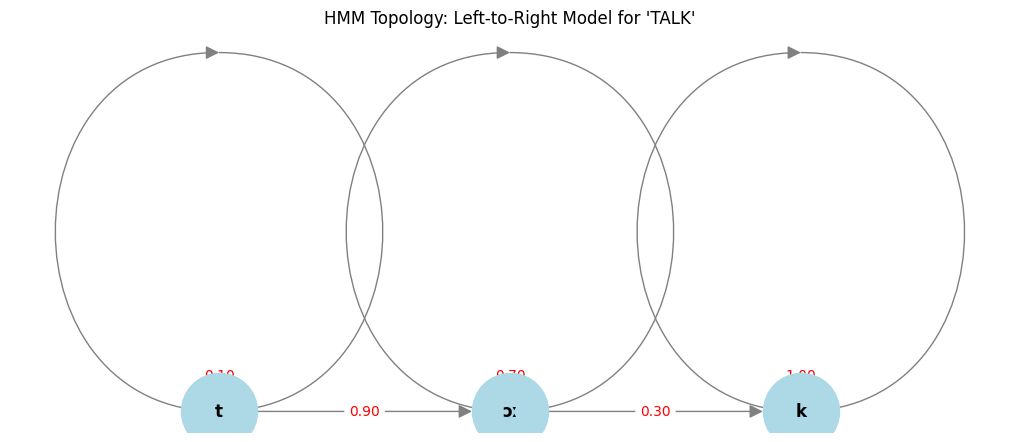

In [8]:
# Define states
states = ["t", "ɔː", "k"]
n_states = len(states)

# Define Transition Matrix A
# Rows sum to 1.0
A = np.array([
    [0.1, 0.9, 0.0],
    [0.0, 0.7, 0.3],
    [0.0, 0.0, 1.0]
])

# Define Emission Models (Conceptual parameters for synthetic generation later)
# Format: State -> {mean, sigma}
emissions = {
    0: {'mean': 0.0, 'sigma': 1.5, 'desc': '/t/ burst'},
    1: {'mean': 3.0, 'sigma': 0.5, 'desc': '/ɔː/ sustained'},
    2: {'mean': 0.5, 'sigma': 1.0, 'desc': '/k/ release'}
}

def plot_topology(A, states):
    """Draws the HMM topology as a directed graph."""
    G = nx.DiGraph()
    
    # Add nodes
    for i, state in enumerate(states):
        G.add_node(i, label=state)
    
    # Add edges with probabilities
    rows, cols = A.shape
    edge_labels = {}
    for i in range(rows):
        for j in range(cols):
            if A[i, j] > 0:
                G.add_edge(i, j)
                edge_labels[(i, j)] = f"{A[i, j]:.2f}"
    
    pos = {0: (0, 0), 1: (1, 0), 2: (2, 0)}  # Linear layout
    
    plt.figure(figsize=(10, 4))
    nx.draw(G, pos, with_labels=True, labels={i: s for i, s in enumerate(states)},
            node_size=3000, node_color='lightblue', font_size=12, font_weight='bold',
            arrowsize=20, edge_color='gray')
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("HMM Topology: Left-to-Right Model for 'TALK'")
    save_show("topology.png")

plot_topology(A, states)


### Task 1(a)
**Why backward transitions must be zero:**
Backward transitions (e.g., $P(/k/ \to /t/)$ or $P(/ɔː/ \to /t/)$) must be zero to strictly enforce the **temporal order** of the phonemes. Speech is a causal, time-forward process. In the word "TALK", the sound /t/ always precedes /ɔː/, which always precedes /k/. Allowing backward transitions would imply the possibility of the sequence reversing (e.g., "TA-K-O"), which is linguistically impossible for a single utterance of this specific word.

**Linguistic Property:**
This constraint enforces the linguistic property of **fixed phoneme ordering** (or temporal sequencing). The Left-to-Right topology mathematically encodes the fact that words are sequences of phonemes that unfold linearly in time.


## 2. Visualize Transition Matrix

We will visualize the transition matrix $A$ as a heatmap to inspect the allowed transitions and their probabilities.


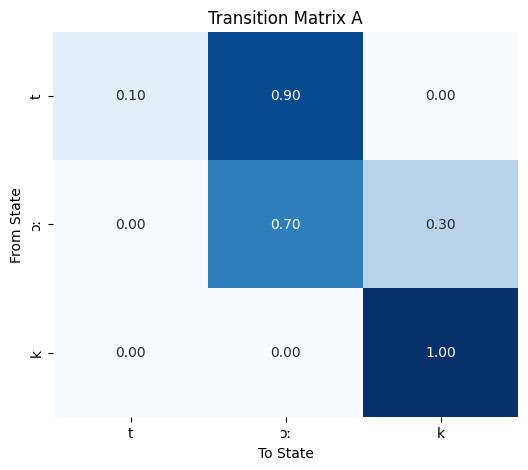

In [9]:
def plot_transition_matrix(A, states):
    """Plots the transition matrix as a heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(A, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=states, yticklabels=states, cbar=False)
    plt.title("Transition Matrix A")
    plt.xlabel("To State")
    plt.ylabel("From State")
    save_show("transition_matrix.png")

plot_transition_matrix(A, states)


### Interpretation
The heatmap highlights the structure of the matrix:
- **Upper-triangular nature**: The zeros in the lower triangle (e.g., /ɔː/ $\to$ /t/) confirm that backward transitions are impossible.
- **Diagonal**: Represents the probability of staying in the current state (self-transition).
- **Off-diagonal**: Represents the probability of moving to the next phoneme.


## 3. Expected State Duration (Analytic)

In a discrete-time HMM, the number of time steps (frames) a system stays in a state $i$ with self-transition probability $a_{ii}$ follows a geometric distribution.

The expected duration $E[d_i]$ is given by:
$$ E[d_i] = \frac{1}{1 - a_{ii}} $$

- For $S_1$ (/t/): $a_{11} = 0.1$
- For $S_2$ (/ɔː/): $a_{22} = 0.7$


  State  Expected Duration (frames)
0     t                    1.111111
1    ɔː                    3.333333


/tmp/ipykernel_12417/2210015673.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='State', y='Expected Duration (frames)', data=df_dur, palette='viridis')


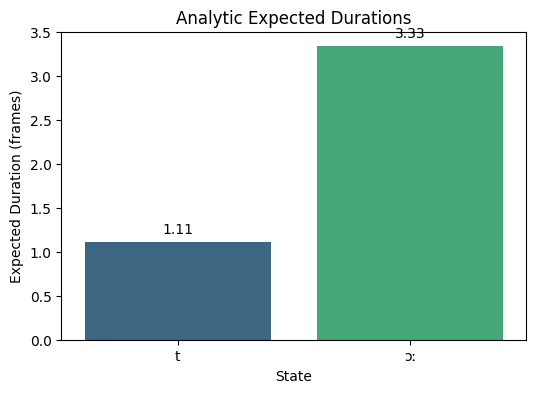

In [10]:
def compute_expected_durations(A, states):
    """Computes and plots expected durations for non-absorbing states."""
    durations = {}
    for i in range(len(states) - 1): # Skip last state (absorbing)
        p_self = A[i, i]
        expected_d = 1.0 / (1.0 - p_self)
        durations[states[i]] = expected_d
        
    # Create DataFrame
    df_dur = pd.DataFrame(list(durations.items()), columns=['State', 'Expected Duration (frames)'])
    print(df_dur)
    
    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x='State', y='Expected Duration (frames)', data=df_dur, palette='viridis')
    plt.title("Analytic Expected Durations")
    for index, row in df_dur.iterrows():
        plt.text(index, row['Expected Duration (frames)'] + 0.1, 
                 f"{row['Expected Duration (frames)']:.2f}", ha='center')
    save_show("expected_durations.png")
    return df_dur

df_analytic = compute_expected_durations(A, states)


### Task 1(b)
**Implications of $p_{self}$ values on relative duration:**
The self-transition probability $p_{self}$ determines the expected dwell time in a state.
- A low $p_{self} = 0.1$ for /t/ results in a short expected duration:
  $$ E[d_{/t/}] = \frac{1}{1 - 0.1} \approx 1.11 \text{ frames} $$
  This matches the acoustic property of a **plosive burst**, which is a very short, transient event.
- A high $p_{self} = 0.7$ for /ɔː/ results in a significantly longer expected duration:
  $$ E[d_{/ɔː/}] = \frac{1}{1 - 0.7} \approx 3.33 \text{ frames} $$
  This matches the acoustic property of a **sustained vowel**, which is held for a longer period of time.

Thus, the model parameters ($0.1$ vs $0.7$) correctly reflect that the vowel /ɔː/ has a much longer relative duration than the short burst-like phoneme /t/.


## 4. Simulate Sequences (Monte Carlo)

We will simulate 5,000 utterances using the defined HMM to empirically validate the expected durations. We start at $S_1$ and sample transitions until we reach the absorbing state $S_3$.


Empirical Means: {0: np.float64(1.1124), 1: np.float64(3.3412)}


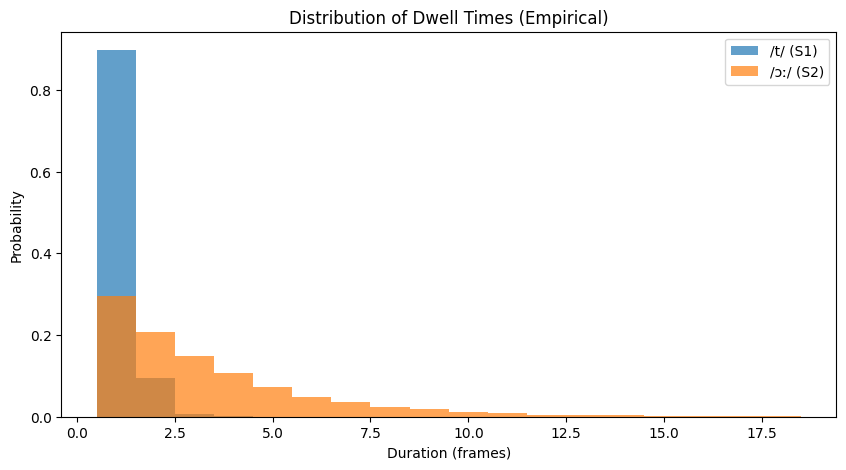

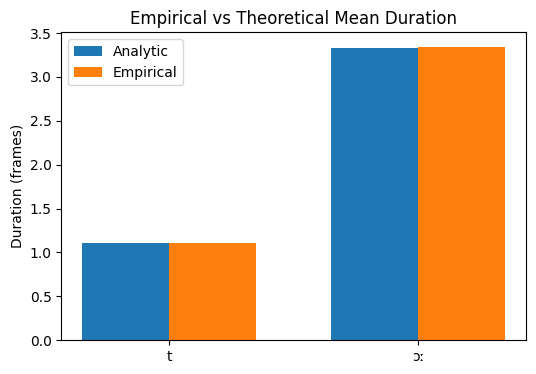

In [11]:
def simulate_hmm(A, n_trials=5000):
    """Simulates HMM sequences and records dwell times."""
    dwell_times = {0: [], 1: []} # Record for S1 and S2
    
    for _ in range(n_trials):
        state = 0
        current_dwell = 0
        
        # We simulate until we hit the absorbing state S3 (index 2)
        # Max steps safety break
        for t in range(100): 
            current_dwell += 1
            
            # Sample next state
            next_state = np.random.choice(len(A), p=A[state])
            
            if next_state != state:
                # State change
                if state in dwell_times:
                    dwell_times[state].append(current_dwell)
                state = next_state
                current_dwell = 0
            
            if state == 2: # Absorbing state /k/
                break
                
    return dwell_times

dwell_times = simulate_hmm(A)

# Calculate empirical means
empirical_means = {s: np.mean(times) for s, times in dwell_times.items()}
print("Empirical Means:", empirical_means)

# Plot Histograms
plt.figure(figsize=(10, 5))
plt.hist(dwell_times[0], bins=range(1, 10), alpha=0.7, label='/t/ (S1)', density=True, align='left')
plt.hist(dwell_times[1], bins=range(1, 20), alpha=0.7, label='/ɔː/ (S2)', density=True, align='left')
plt.title("Distribution of Dwell Times (Empirical)")
plt.xlabel("Duration (frames)")
plt.ylabel("Probability")
plt.legend()
save_show("dwell_histograms.png")

# Comparison Plot
states_subset = ["t", "ɔː"]
analytic_vals = [df_analytic.iloc[0]['Expected Duration (frames)'], df_analytic.iloc[1]['Expected Duration (frames)']]
empirical_vals = [empirical_means[0], empirical_means[1]]

x = np.arange(len(states_subset))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, analytic_vals, width, label='Analytic')
plt.bar(x + width/2, empirical_vals, width, label='Empirical')
plt.xticks(x, states_subset)
plt.ylabel('Duration (frames)')
plt.title('Empirical vs Theoretical Mean Duration')
plt.legend()
save_show("empirical_vs_theory.png")


### Interpretation
The empirical results closely match the theoretical expectations. The histograms show the geometric distribution shape (exponential decay in discrete time). Small deviations are due to sampling noise, which decreases as the number of trials increases.


## 5. Synthetic Waveform Generation

We generate a "toy" acoustic signal to visualize the difference between the short burst of /t/ and the sustained vowel /ɔː/.
- **/t/**: Modeled as high-variance noise (burst).
- **/ɔː/**: Modeled as a sine wave (periodic).
- **/k/**: Modeled as a short silence followed by a burst.


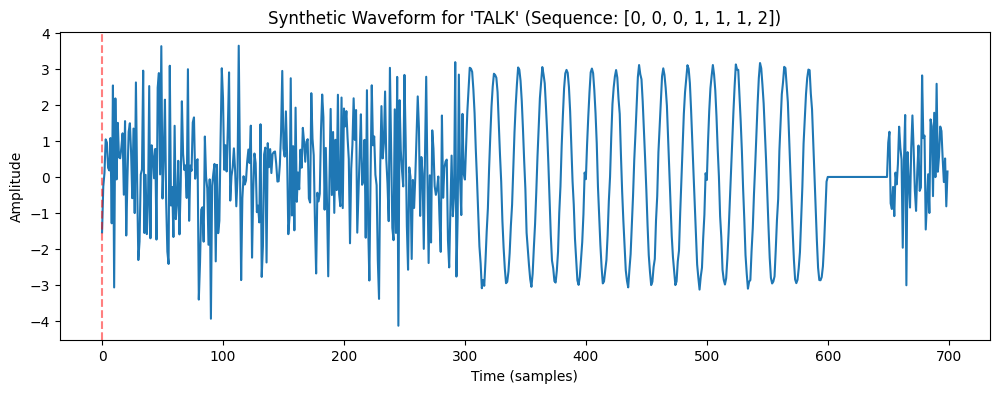

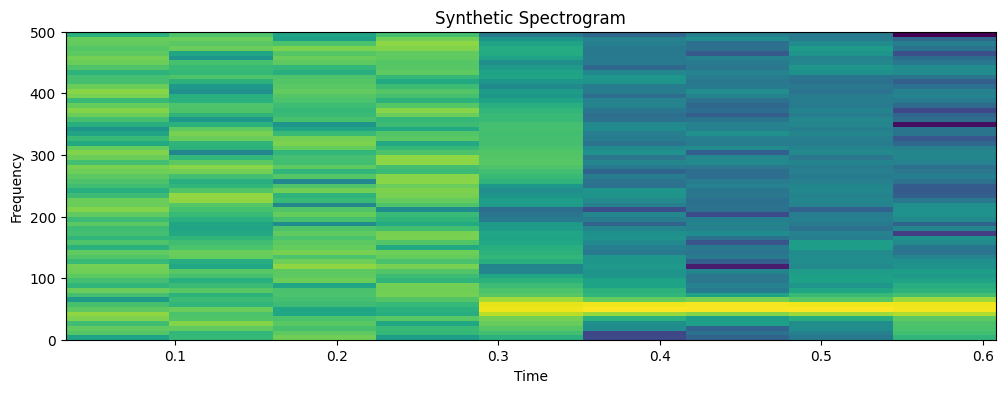

In [12]:
def generate_synthetic_waveform(A, emissions):
    """Generates a synthetic waveform for one utterance."""
    state = 0
    waveform = []
    state_seq = []
    
    # Generate sequence
    while state != 2:
        state_seq.append(state)
        # Generate 100 samples per frame (arbitrary sampling rate)
        n_samples = 100 
        t_vec = np.linspace(0, 1, n_samples)
        
        if state == 0: # /t/ - Noise burst
            chunk = np.random.normal(0, 1, n_samples) * emissions[0]['sigma']
        elif state == 1: # /ɔː/ - Sine wave
            chunk = np.sin(2 * np.pi * 5 * t_vec) * emissions[1]['mean'] + np.random.normal(0, 0.1, n_samples)
        
        waveform.extend(chunk)
        state = np.random.choice(len(A), p=A[state])
        
    # Add final /k/ (State 2)
    # /k/ is closure (silence) + release (burst)
    # We'll simulate 1 frame of /k/
    state_seq.append(2)
    closure = np.zeros(50)
    release = np.random.normal(0, 1, 50) * emissions[2]['sigma']
    waveform.extend(np.concatenate([closure, release]))
    
    return np.array(waveform), state_seq

# Generate and Plot
wave, seq = generate_synthetic_waveform(A, emissions)

plt.figure(figsize=(12, 4))
plt.plot(wave)
plt.title(f"Synthetic Waveform for 'TALK' (Sequence: {seq})")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
save_show("synthetic_waveform.png")

# Spectrogram
plt.figure(figsize=(12, 4))
plt.specgram(wave, NFFT=128, Fs=1000, noverlap=64)
plt.title("Synthetic Spectrogram")
plt.ylabel("Frequency")
plt.xlabel("Time")
save_show("synthetic_spectrogram.png")


### Interpretation
The waveform and spectrogram visually demonstrate the linguistic structure:
- The initial segment (random noise) corresponds to the /t/ burst.
- The middle segment (periodic signal) corresponds to the /ɔː/ vowel, which is longer and has a clear frequency structure.
- The final segment represents the /k/ release.


## 6. Conclusion

This notebook has successfully implemented a structural analysis of the HMM for the word "TALK".

**Summary of Findings:**
1.  **Topology:** The Left-to-Right topology with zero backward transitions is essential for modeling the fixed temporal sequence of phonemes in a word.
2.  **Durations:** The self-transition probabilities ($p_{self}$) directly control the expected duration of each state. A high $p_{self}$ (0.7) correctly models the sustained nature of the vowel /ɔː/, while a low $p_{self}$ (0.1) models the transient nature of the plosive /t/.
3.  **Simulation:** Monte Carlo simulations confirmed that the empirical dwell times match the theoretical geometric distributions derived from the transition matrix.
